In [1]:
# import libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler , RobustScaler , MinMaxScaler
import re
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dropout, Dense
from transformers import BertTokenizer, BertForSequenceClassification
import torch
from keras.callbacks import EarlyStopping
from sklearn.metrics import r2_score , mean_absolute_error

In [2]:
# Load Data
News_DATA=pd.read_csv("/content/News_DATA.csv")
DJIA_DATA=pd.read_csv("/content/DJIA_DATA.csv")

In [3]:
#DJIA Stock Data Exploration And Preprocessing

In [4]:
DJIA_DATA

,Date,Open,High,Low,Close,Volume
0,2011-01-03,11577.429688,11711.469727,11577.349609,11670.75,203420000
1,2011-01-04,11670.900391,11698.219727,11635.740234,11691.179688,178630000
2,2011-01-05,11688.610352,11742.679688,11652.889648,11722.889648,169990000
3,2011-01-06,11716.929688,11736.740234,11667.459961,11697.30957,193080000
4,2011-01-07,11696.860352,11726.94043,11599.679688,11674.759766,188720000
...,...,...,...,...,...,...
2512,2020-12-24,"30,155.92","30,209.67","30,099.30","30,199.87","14,55,70,000"
2513,2020-12-28,"30,283.23","30,525.56","30,283.23","30,403.97","30,24,90,000"
2514,2020-12-29,"30,492.07","30,588.79","30,274.24","30,335.67","35,76,10,000"
2515,2020-12-30,"30,415.09","30,525.35","30,393.04","30,409.56","29,18,90,000"


In [5]:
# Clean and convert DJIA columns by removing commas and converting to float
columns_to_fix = ["Open", "High", "Low", "Close", "Volume"]

for col in columns_to_fix:
    DJIA_DATA[col] = DJIA_DATA[col].astype(str).str.replace(",", "").astype(float)


In [6]:
DJIA_DATA.head()

,Date,Open,High,Low,Close,Volume
0,2011-01-03,11577.429688,11711.469727,11577.349609,11670.750000,203420000.0
1,2011-01-04,11670.900391,11698.219727,11635.740234,11691.179688,178630000.0
2,2011-01-05,11688.610352,11742.679688,11652.889648,11722.889648,169990000.0
3,2011-01-06,11716.929688,11736.740234,11667.459961,11697.309570,193080000.0
4,2011-01-07,11696.860352,11726.940430,11599.679688,11674.759766,188720000.0


In [7]:
#Date Formatting and Sort by Date
DJIA_DATA['Date'] = pd.to_datetime(DJIA_DATA['Date'])
DJIA_DATA.sort_values(by='Date', inplace=True)
DJIA_DATA.reset_index(drop=True, inplace=True)

In [8]:
DJIA_DATA.describe()

,Date,Open,High,Low,Close,Volume
count,2517,2517.000000,2517.000000,2517.000000,2517.000000,2.517000e+03
mean,2016-01-02 10:45:54.707985664,19230.749448,19331.182433,19125.416186,19234.572579,2.114781e+08
min,2011-01-03 00:00:00,10651.440430,10808.490234,10404.490234,10655.299805,8.410000e+06
25%,2013-07-05 00:00:00,15112.570312,15192.129883,15044.799805,15115.570312,1.032200e+08
50%,2016-01-04 00:00:00,17849.460938,17929.509766,17768.599609,17851.509766,1.581700e+08
75%,2018-07-03 00:00:00,24585.710000,24750.730000,24442.560000,24597.370000,2.977800e+08
max,2020-12-31 00:00:00,30492.070000,30637.470000,30393.040000,30606.480000,9.159900e+08
std,NaN,5321.325993,5347.943039,5291.164619,5319.039955,1.363436e+08


In [9]:
DJIA_DATA.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2517 entries, 0 to 2516
Data columns (total 6 columns):
 #   Column  Non-Null Count  Dtype         
---  ------  --------------  -----         
 0   Date    2517 non-null   datetime64[ns]
 1   Open    2517 non-null   float64       
 2   High    2517 non-null   float64       
 3   Low     2517 non-null   float64       
 4   Close   2517 non-null   float64       
 5   Volume  2517 non-null   float64       
dtypes: datetime64[ns](1), float64(5)
memory usage: 118.1 KB


In [10]:
#check Missing Values
print("Missing values:\n", DJIA_DATA.isnull().sum())

Missing values:
 Date      0
Open      0
High      0
Low       0
Close     0
Volume    0
dtype: int64


In [11]:
#check duplicates
duplicates = DJIA_DATA.duplicated()
print("sum of duplicates", duplicates.sum())
duplicates = DJIA_DATA['Date'].duplicated()
print("Sum of duplicate dates:", duplicates.sum())

sum of duplicates 0
Sum of duplicate dates: 0


In [12]:
#check outliers
for col in ['Open', 'High', 'Low', 'Close', 'Volume']:
    Q1 = DJIA_DATA[col].quantile(0.25)
    Q3 = DJIA_DATA[col].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    outliers = DJIA_DATA[(DJIA_DATA[col] < lower_bound) | (DJIA_DATA[col] > upper_bound)]
    print(f'{col}: {len(outliers)} outliers')


Open: 0 outliers
High: 0 outliers
Low: 0 outliers
Close: 0 outliers
Volume: 43 outliers


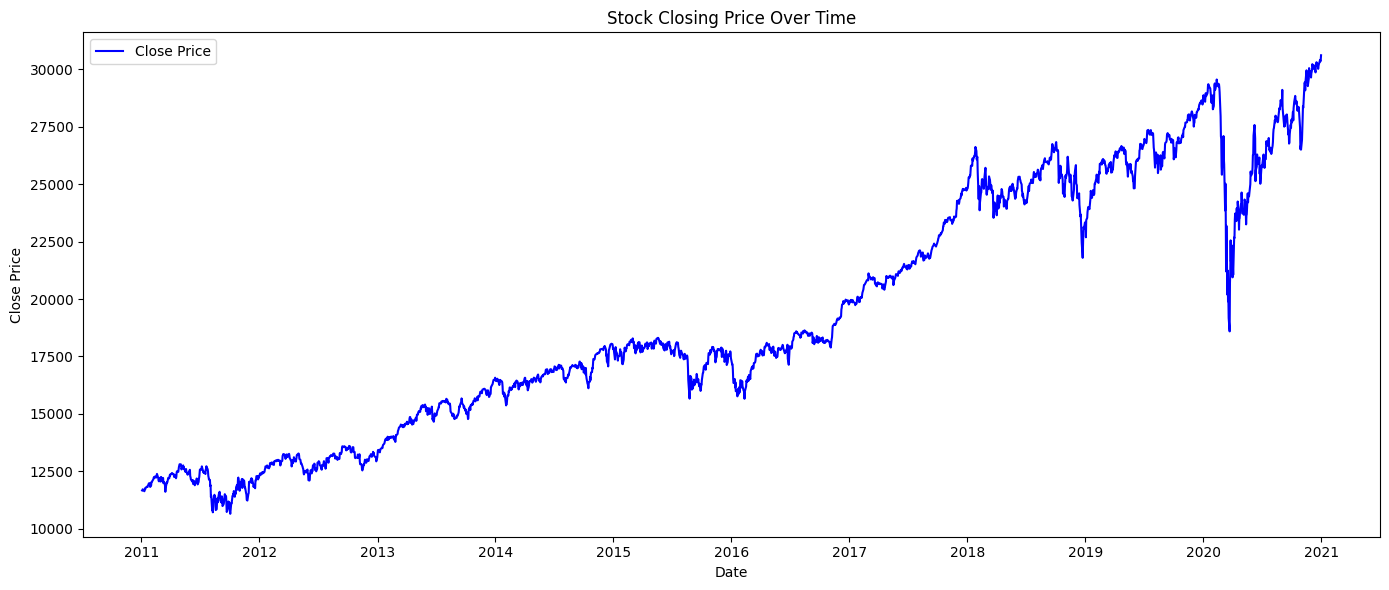

In [13]:
#plotted the time series of the closing prices :
plt.figure(figsize=(14, 6))
plt.plot(DJIA_DATA['Date'], DJIA_DATA['Close'], label='Close Price', color='blue')
plt.title('Stock Closing Price Over Time')
plt.xlabel('Date')
plt.ylabel('Close Price')
plt.legend()
plt.tight_layout()
plt.show()

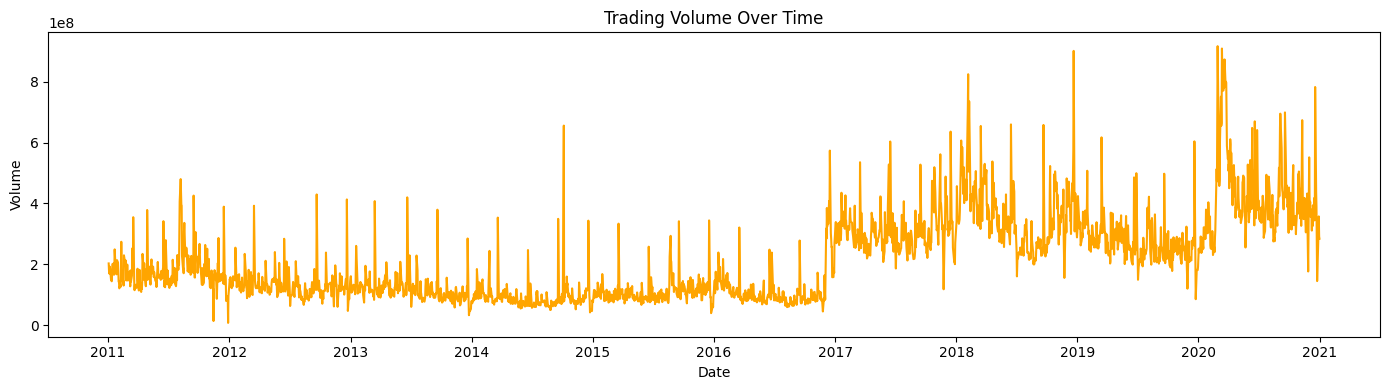

In [14]:
#plotted the time series of the trading volume:
plt.figure(figsize=(14, 4))
plt.plot(DJIA_DATA['Date'], DJIA_DATA['Volume'], label='Volume', color='orange')
plt.title('Trading Volume Over Time')
plt.xlabel('Date')
plt.ylabel('Volume')
plt.tight_layout()
plt.show()

In [15]:
#Correlation Analysis:

features = ['Open', 'High', 'Low', 'Close', 'Volume']
corr_matrix = DJIA_DATA[features].corr()

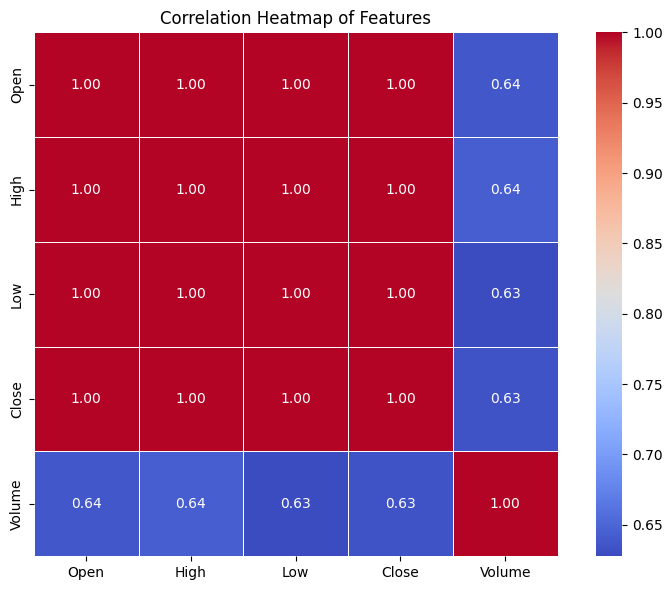

In [16]:
plt.figure(figsize=(8, 6))
sns.heatmap(corr_matrix, annot=True, fmt=".2f", cmap='coolwarm', square=True, linewidths=0.5)
plt.title('Correlation Heatmap of Features')
plt.tight_layout()
plt.show()

In [17]:
#News_DATA Exploration And Preprocessing

In [18]:
# Define a function to clean text data
def clean_text(text):
    text = re.sub(r'http\S+|www\.\S+', '', text)
    text = re.sub(r'<.*?>', '', text)
    text = re.sub(r'[^a-zA-Z\s]', '', text)
    text = text.lower()
    text = text.strip()
    return text

# Apply text cleaning to the 'headline' column
News_DATA['headline'] = News_DATA['headline'].astype(str).apply(clean_text)

In [19]:
# Load the model and tokenizer
finbert = BertForSequenceClassification.from_pretrained('yiyanghkust/finbert-tone', num_labels=3)
tokenizer = BertTokenizer.from_pretrained('yiyanghkust/finbert-tone')

# Set the model to evaluation mode
finbert.eval()

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
finbert.to(device)

batch_size = 1000
all_predictions = []

for i in range(0, len(News_DATA), batch_size):
    batch_sentences = News_DATA["headline"].iloc[i:i+batch_size].astype(str).tolist()
    inputs = tokenizer(batch_sentences, return_tensors="pt", padding=True, truncation=True, max_length=512)
    inputs = {key: val.to(device) for key, val in inputs.items()}

    with torch.no_grad():
        outputs = finbert(**inputs).logits

    predictions = torch.argmax(outputs, dim=1).cpu().numpy()
    all_predictions.extend(predictions)

label_mapping = {0: 0, 1: 1, 2:-1}
mapped_predictions = [label_mapping[pred] for pred in all_predictions]

News_DATA["Sentiment"] = mapped_predictions



/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


In [20]:
#Take the mean of Sentiment per day
daily_avg_sentiment = News_DATA.groupby("date")["Sentiment"].mean().reset_index()
daily_avg_sentiment.rename(columns={"Sentiment": "Day_Sentiments"}, inplace=True)

News_DATA = News_DATA.merge(daily_avg_sentiment, on="date", how="left")



In [21]:
News_DATA= News_DATA[['date', 'Day_Sentiments']]

In [22]:
News_DATA.drop_duplicates(inplace=True)

In [23]:
News_DATA

,date,Day_Sentiments
0,2011-01-03,0.000000
2,2011-01-04,0.250000
6,2011-01-05,0.000000
7,2011-01-06,0.500000
9,2011-01-07,-1.000000
...,...,...
21097,2020-12-24,0.000000
21103,2020-12-28,0.000000
21110,2020-12-29,0.200000
21120,2020-12-30,0.214286


In [24]:
#Rename columns
DJIA_DATA.rename(columns={'Date': 'date'}, inplace=True)

In [25]:
DJIA_DATA

,date,Open,High,Low,Close,Volume
0,2011-01-03,11577.429688,11711.469727,11577.349609,11670.750000,203420000.0
1,2011-01-04,11670.900391,11698.219727,11635.740234,11691.179688,178630000.0
2,2011-01-05,11688.610352,11742.679688,11652.889648,11722.889648,169990000.0
3,2011-01-06,11716.929688,11736.740234,11667.459961,11697.309570,193080000.0
4,2011-01-07,11696.860352,11726.940430,11599.679688,11674.759766,188720000.0
...,...,...,...,...,...,...
2512,2020-12-24,30155.920000,30209.670000,30099.300000,30199.870000,145570000.0
2513,2020-12-28,30283.230000,30525.560000,30283.230000,30403.970000,302490000.0
2514,2020-12-29,30492.070000,30588.790000,30274.240000,30335.670000,357610000.0
2515,2020-12-30,30415.090000,30525.350000,30393.040000,30409.560000,291890000.0


In [26]:
# merge_data
News_DATA['date'] = pd.to_datetime(News_DATA['date'])
DJIA_DATA['date'] = pd.to_datetime(DJIA_DATA['date'])

merge_data = News_DATA.merge(DJIA_DATA, how='inner', on='date')

In [27]:
Final_Data=merge_data[['date','Day_Sentiments','Open','High','Low','Volume','Close']]

In [28]:
Final_Data.head(14)

,date,Day_Sentiments,Open,High,Low,Volume,Close
0,2011-01-03,0.00,11577.429688,11711.469727,11577.349609,203420000.0,11670.750000
1,2011-01-04,0.25,11670.900391,11698.219727,11635.740234,178630000.0,11691.179688
2,2011-01-05,0.00,11688.610352,11742.679688,11652.889648,169990000.0,11722.889648
3,2011-01-06,0.50,11716.929688,11736.740234,11667.459961,193080000.0,11697.309570
4,2011-01-07,-1.00,11696.860352,11726.940430,11599.679688,188720000.0,11674.759766
5,2011-01-10,-0.50,11672.339844,11677.330078,11573.870117,150340000.0,11637.450195
6,2011-01-11,0.50,11638.509766,11704.120117,11635.480469,157440000.0,11671.879883
7,2011-01-12,-0.50,11673.620117,11782.230469,11673.620117,144960000.0,11755.440430
8,2011-01-13,-0.20,11753.700195,11757.250000,11700.530273,161660000.0,11731.900391
9,2011-01-14,0.50,11732.129883,11794.150391,11698.830078,200770000.0,11787.379883


In [29]:
data = Final_Data[['date', 'Close', 'Open', 'High', 'Low', 'Volume', 'Day_Sentiments']].copy()
data = data.sort_values('date').reset_index(drop=True)

In [30]:

# Build a sequences and Determine window size

def create_sequences(df, window_size):
    X, y = [], []
    for i in range(window_size, len(df)):
        X.append(df.iloc[i-window_size:i][['Open', 'High', 'Low', 'Volume', 'Day_Sentiments']].values)
        y.append(df.iloc[i]['Close'])
    return np.array(X), np.array(y)

window_size = 5
X_raw, y_raw = create_sequences(data, window_size)


In [31]:
# Split the dataset into training (70%), validation (15%), and test (15%) sets

n = len(X_raw)
train_end = int(n * 0.7)
val_end = int(n * 0.85)

X_train_raw = X_raw[:train_end]
y_train_raw = y_raw[:train_end]
X_val_raw = X_raw[train_end:val_end]
y_val_raw = y_raw[train_end:val_end]
X_test_raw = X_raw[val_end:]
y_test_raw = y_raw[val_end:]

In [32]:
minmax_scaler = MinMaxScaler()
robust_scaler = RobustScaler()


def scale_features(X, fit=False):
    X_reshaped = X.reshape(-1, X.shape[-1])
    open_high_low_sent = X_reshaped[:, [0, 1, 2, 4]]
    volume = X_reshaped[:, [3]]

    if fit:
        open_high_low_sent_scaled = minmax_scaler.fit_transform(open_high_low_sent)
        volume_scaled = robust_scaler.fit_transform(volume)
    else:
        open_high_low_sent_scaled = minmax_scaler.transform(open_high_low_sent)
        volume_scaled = robust_scaler.transform(volume)


    X_scaled = np.concatenate([open_high_low_sent_scaled[:, 0:1],
                               open_high_low_sent_scaled[:, 1:2],
                               open_high_low_sent_scaled[:, 2:3],
                               volume_scaled,
                               open_high_low_sent_scaled[:, 3:]], axis=1)

    return X_scaled.reshape(X.shape)

X_train = scale_features(X_train_raw, fit=True)
X_val = scale_features(X_val_raw)
X_test = scale_features(X_test_raw)

y_scaler = MinMaxScaler()
y_train = y_scaler.fit_transform(y_train_raw.reshape(-1, 1)).flatten()
y_val = y_scaler.transform(y_val_raw.reshape(-1, 1)).flatten()
y_test = y_scaler.transform(y_test_raw.reshape(-1, 1)).flatten()

In [33]:
# Build and compile an LSTM model for regression
model = Sequential()
model.add(LSTM(64, input_shape=(X_train.shape[1], X_train.shape[2]) ))
model.add(Dropout(0.2))

model.add(Dense(1)) # Output layer for predicting a single value
model.compile(optimizer='adam', loss='mse', metrics=['mae'])

# Early Stopping
early_stop = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [34]:
# Train the LSTM model with training data, using validation data and early stopping

history = model.fit(
    X_train, y_train,
    epochs=50,
    batch_size=32,
    validation_data=(X_val, y_val),
    callbacks=[early_stop]
)

Epoch 1/50
55/55 ━━━━━━━━━━━━━━━━━━━━ 3s 10ms/step - loss: 0.0617 - mae: 0.1837 - val_loss: 0.0031 - val_mae: 0.0477
Epoch 2/50
55/55 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0051 - mae: 0.0523 - val_loss: 0.0015 - val_mae: 0.0323
Epoch 3/50
55/55 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0037 - mae: 0.0449 - val_loss: 9.8249e-04 - val_mae: 0.0241
Epoch 4/50
55/55 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 0.0030 - mae: 0.0406 - val_loss: 7.1705e-04 - val_mae: 0.0202
Epoch 5/50
55/55 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 0.0026 - mae: 0.0366 - val_loss: 0.0064 - val_mae: 0.0738
Epoch 6/50
55/55 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 0.0026 - mae: 0.0362 - val_loss: 0.0013 - val_mae: 0.0289
Epoch 7/50
55/55 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0023 - mae: 0.0347 - val_loss: 8.0555e-04 - val_mae: 0.0214
Epoch 8/50
55/55 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0019 - mae: 0.0308 - val_loss: 8.6228e-04 - val_mae: 0.0210
Epoch 9/50
55/55 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - l

In [35]:
# Make predictions on the test set and evaluate the model using R² score
y_pred = model.predict(X_test)
r2 = r2_score(y_test, y_pred)
print(f"R² score: {r2:.4f}")
mae = mean_absolute_error(y_test, y_pred)
print(f"MAE: {mae:.4f}")


12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
R² score: 0.9014
MAE: 0.0317


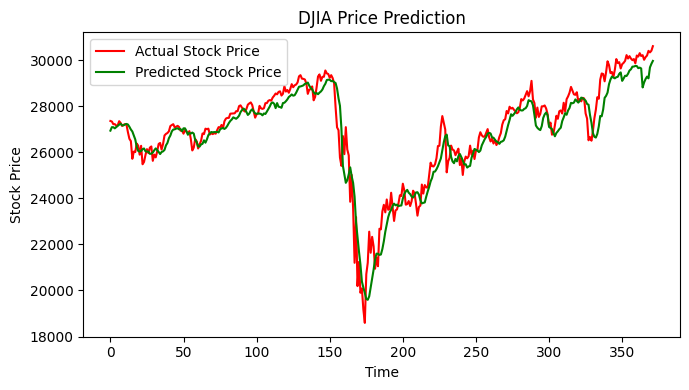

In [36]:
predicted_price = y_scaler.inverse_transform(y_pred.reshape(-1, 1)).flatten()
Y_test = y_scaler.inverse_transform(y_test.reshape(-1, 1)).flatten()

plt.figure(figsize=(7, 4))
plt.plot(Y_test, color='red', label='Actual Stock Price')
plt.plot(predicted_price, color='green', label='Predicted Stock Price')
plt.title('DJIA Price Prediction')
plt.xlabel('Time')
plt.ylabel('Stock Price')
plt.legend()
plt.tight_layout()
plt.show()